In [1]:
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import HTML
%config InlineBackend.figure_format ='retina'

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import os
import json
import requests

import scipy as sp
from scipy import signal

from pathlib import Path

from sunpy.net import Fido
from sunpy.net import attrs as a

from tsmoothie.smoother import *

from astral.sun import sun
from astral import LocationInfo

In [2]:
#This makes a list of usable files from the specificed location and joins them. Shown below.
path = 'insert path here'

files = Path(path).glob('*.csv')

groups = list()
for i in (files):
    group = pd.read_csv(i, skiprows=16, delimiter=',', usecols=['DHO'], skipinitialspace=True, names=['datetimes', 'DHO'])
    groups.append(group)

group = pd.concat(groups, 'columns', ignore_index=True)

/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/1209270776.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  group = pd.concat(groups, 'columns', ignore_index=True)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,921171.583689,723601.718816,1.228311e+06,807940.440676,1.079517e+06,1.253580e+06,965015.892100,792828.438945,910145.535071,702816.286154,...,701752.707330,709765.962806,1.501125e+06,314962.086143,816703.089598,820982.554535,722587.364801,400070.212696,1.466333e+06,1.156582e+06
1,910686.452830,718736.602993,1.223803e+06,806737.322237,1.075682e+06,1.251770e+06,963384.188165,792828.438945,909900.681126,703143.420063,...,701313.281338,709765.962806,1.496218e+06,314772.335185,816703.089598,820712.208006,722587.364801,400070.212696,1.466333e+06,1.154100e+06
2,900201.321972,713871.487170,1.219295e+06,805534.203798,1.071847e+06,1.249961e+06,961752.484231,792828.438945,909655.827181,701694.499585,...,700873.855346,710738.833199,1.491312e+06,314582.584227,816703.089598,820441.861476,722587.364801,400070.212696,1.466333e+06,1.151618e+06
3,889716.191113,709006.371347,1.214787e+06,804331.085359,1.068012e+06,1.248151e+06,960120.780296,796501.453727,909410.973237,700245.579106,...,700434.429354,711711.703591,1.486405e+06,314392.833269,816703.089598,820171.514947,721981.821616,400070.212696,1.466333e+06,1.149137e+06
4,879231.060255,704141.255524,1.210279e+06,803127.966920,1.062675e+06,1.246342e+06,958489.076362,800174.468509,909166.119292,698796.658628,...,699995.003362,712684.573984,1.476555e+06,313739.939115,816703.089598,819901.168418,721376.278431,400070.212696,1.466639e+06,1.146655e+06


(43200, 22)


In [3]:
#Reads in data from given csv and adds a column with mean data
Birr = pd.read_csv('csv location path', skiprows=16, delimiter=',',  skipinitialspace=True, names=['datetimes', 'DHO'])

frames = list()
frames.append(Birr)
frames.append(group.mean(axis=1))
prep = pd.concat(frames, 'columns', ignore_index=True)

/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/2983239355.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  prep = pd.concat(frames, 'columns', ignore_index=True)


,0,1,2
0,2023-05-20 00:00:00,1.107910e+06,900112.253971
1,2023-05-20 00:00:02,1.107910e+06,898305.011190
2,2023-05-20 00:00:04,1.109809e+06,896463.560347
3,2023-05-20 00:00:06,1.111708e+06,894779.724519
4,2023-05-20 00:00:08,1.113607e+06,892795.755570


In [4]:
#Makes the pandas df with the deviation from the mean
final = list()
final.append(prep[0])
final.append((20*np.log10(prep[1]))-(20*np.log10(prep[2])))
AvgDev = pd.concat(final, 'columns', ignore_index=True)

/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/2922748167.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  AvgDev = pd.concat(final, 'columns', ignore_index=True)


,0,1
0,2023-05-20 00:00:00,1.804156
1,2023-05-20 00:00:02,1.821613
2,2023-05-20 00:00:04,1.854312
3,2023-05-20 00:00:06,1.885493
4,2023-05-20 00:00:08,1.919598


In [5]:
# Converting the VLF time data to datetime object
# Create a new list
time_dho = []
# For each time value in the datetimes column of the vlf data, convert it to 
# a datetime object and append it to the new list (time_naa)
for i in AvgDev[0]:
    time_dho.append(datetime.strptime(i, '%Y-%m-%d %H:%M:%S'))

#Clean vlf data by replacing infinite values with nans (makes for better plotting)
vlf_fix_dB = (AvgDev[1])
vlf_fix_dB[vlf_fix_dB == -np.inf] = np.nan
vlf_fix_dB[vlf_fix_dB == +np.inf] = np.nan

#Smooth data for ease of interpreting
gaussian = GaussianSmoother(n_knots=300, sigma=0.00001)
gaussian.smooth(vlf_fix_dB)
vlf_filtered_dB = gaussian.smooth_data[0]

#Additional interval for possible noise detection
low, up = gaussian.get_intervals('prediction_interval')

/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/500466486.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vlf_fix_dB[vlf_fix_dB == -np.inf] = np.nan
/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/500466486.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vlf_fix_dB[vlf_fix_dB == +np.inf] = np.nan


[1.41881623 1.4129193  1.40704256 ... 1.17656092 1.18525942 1.19395534]
[3.9501075  3.94380658 3.93753287 ... 3.70684264 3.71593241 3.72502661]


In [6]:
#Combining filtering info into one dataframe
upper = pd.DataFrame(up[0], columns=['up'])
lower = pd.DataFrame(low[0], columns=['low'])
filtered = pd.DataFrame(vlf_filtered_dB, columns=['data'])
time = pd.DataFrame(time_dho, columns=['time'])

noisecheck = list()
noisecheck.append(filtered)
noisecheck.append(upper)
noisecheck.append(lower)
Noise = pd.concat(noisecheck, 'columns', ignore_index=True)

              0         1         2
0      2.684462  3.950107  1.418816
1      2.678363  3.943807  1.412919
2      2.672288  3.937533  1.407043
3      2.666237  3.931287  1.401187
4      2.660212  3.925071  1.395353
...         ...       ...       ...
43195  2.423920  3.688680  1.159160
43196  2.432810  3.697758  1.167861
43197  2.441702  3.706843  1.176561
43198  2.450596  3.715932  1.185259
43199  2.459491  3.725027  1.193955

[43200 rows x 3 columns]


/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/1914527446.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  Noise = pd.concat(noisecheck, 'columns', ignore_index=True)


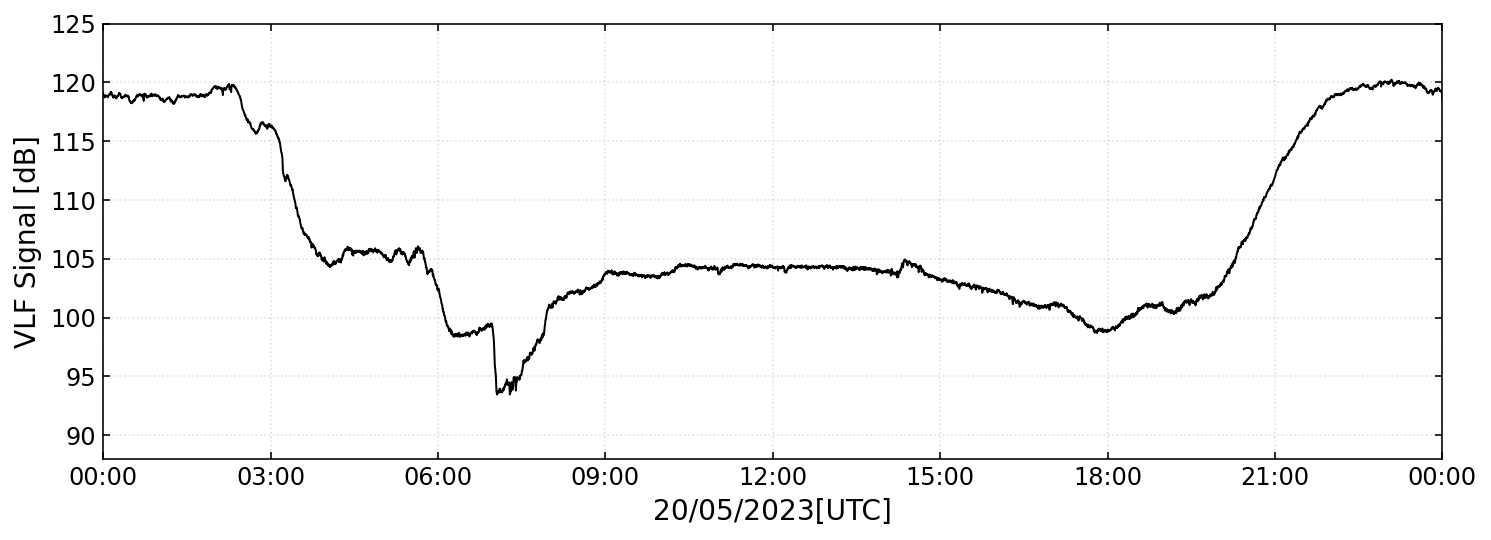

In [7]:
# Plot to show mean intensity to check for abnormalities
# Create a figure
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

# Plot the mean data
ax.plot(time_dho, 20*np.log10(prep[2]), color='k', lw=1, ls='-', label='VLF DHO Average', alpha=1)

# Set the x label to be the current date in the first time object 
ax.set_xlabel(str(time_dho[0].strftime("%d/%m/%Y"))+ '[UTC]', fontsize=14)
# Set y-value to string below.
ax.set_ylabel('VLF Signal [dB]', fontsize=14)

# Set x-axis limit to be start time with a window of 1 day
ax.set_xlim(time_dho[0], time_dho[0]+timedelta(days=1))
# Set y-axis limit to be 80 dB to the max recorded dB in the data +5 dB
ax.set_ylim(int(np.min(20*np.log10(prep[2]))-5), int(np.max(20*np.log10(prep[2]))+5))

# Make the x-axis appear in time format (Hours:mins)
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")

# plot a grid
plt.grid(alpha=0.4, ls='dotted')

plt.show()

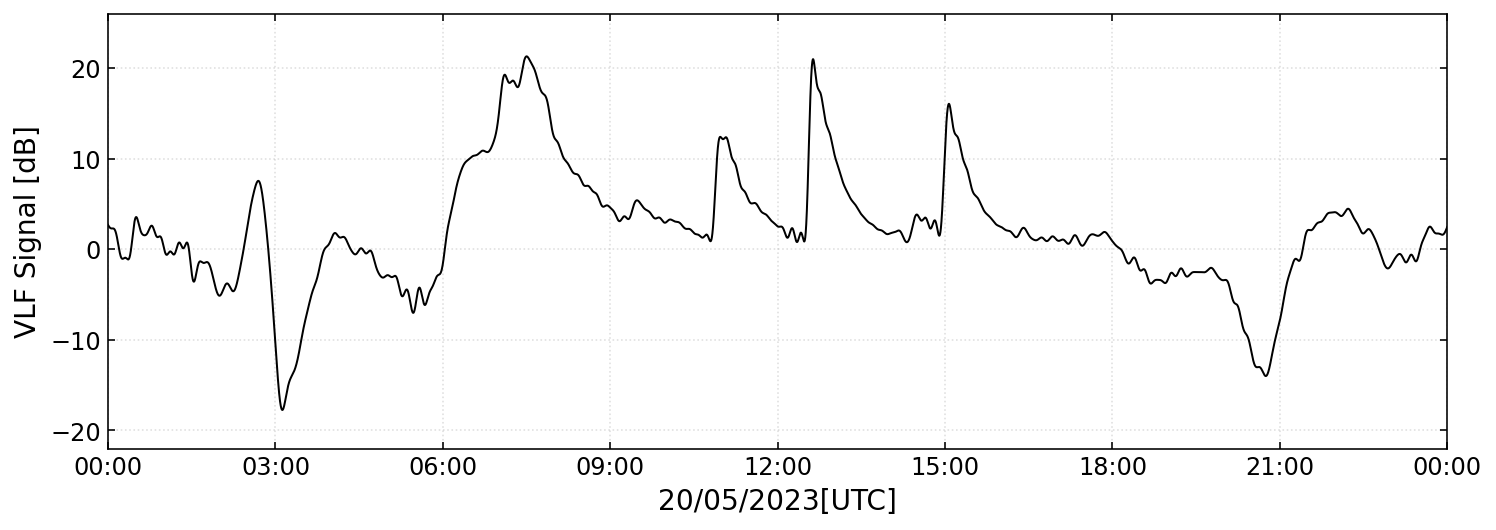

In [8]:
# Create a figure
fig = plt.figure(figsize=(12,4))
ax = plt.gca()

# Plot the data
ax.plot(time_dho, vlf_filtered_dB, color='k', lw=1, ls='-', label='VLF DHO Adjusted', alpha=1)

# Set the x label to be the current date in the first time object 
ax.set_xlabel(str(time_dho[0].strftime("%d/%m/%Y"))+ '[UTC]', fontsize=14)
# Set y-value to string below.
ax.set_ylabel('VLF Signal [dB]', fontsize=14)

# Set x-axis limit to be start time with a window of 1 day
ax.set_xlim(time_dho[0], time_dho[0]+timedelta(days=1))
# Set y-axis limit to be 80 dB to the max recorded dB in the data +5 dB
ax.set_ylim(int(np.min(vlf_filtered_dB)-5), int(np.max(vlf_filtered_dB)+5))

# Make the x-axis appear in time format (Hours:mins)
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")

# plot a grid
plt.grid(alpha=0.4, ls='dotted')

plt.show()

In [9]:
#Converts the filtered data back to a dataframe and pairs it back with time.
filtered_dB = pd.DataFrame(vlf_filtered_dB, columns=['Filtered'])

reports = list()
reports.append(AvgDev[0])
reports.append(filtered_dB)
reportlist = pd.concat(reports, 'columns', ignore_index=True)

/var/folders/by/0cghdhd51jbfww2jjf1nncw00000gn/T/ipykernel_34473/1637432120.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  reportlist = pd.concat(reports, 'columns', ignore_index=True)


,0,1
0,2023-05-20 00:00:00,2.684462
1,2023-05-20 00:00:02,2.678363
2,2023-05-20 00:00:04,2.672288
3,2023-05-20 00:00:06,2.666237
4,2023-05-20 00:00:08,2.660212


In [10]:
#Using scipy signal.find_peaks and assigning it to variables.
peakamp = []
peaktime = []

peaktime = reportlist[0][(signal.find_peaks(reportlist[1], 10, 0.00001, (10*(60/2)))[0])]

peakamp= reportlist[1][(signal.find_peaks(reportlist[1], 10, 0.00001, (10*(60/2)))[0])]

12797    2023-05-20 07:06:34
13503    2023-05-20 07:30:06
19749    2023-05-20 10:58:18
22743    2023-05-20 12:38:06
27125    2023-05-20 15:04:10
Name: 0, dtype: object
12797    19.268777
13503    21.294334
19749    12.409419
22743    20.983072
27125    16.054876
Name: 1, dtype: float64


In [11]:
#Converts to DataFrame for ease of use. Not a requirement but quality of life.
listObj = [peaktime,peakamp]
ser = pd.DataFrame(listObj)

                 12797                13503                19749  \
0  2023-05-20 07:06:34  2023-05-20 07:30:06  2023-05-20 10:58:18   
1            19.268777            21.294334            12.409419   

                 22743                27125  
0  2023-05-20 12:38:06  2023-05-20 15:04:10  
1            20.983072            16.054876  


In [12]:
# Get GOES flares for the given date:
event_type = "FL"
tstart = "2023/05/20"
tend = "2023/05/21"
result = Fido.search(a.Time(tstart, tend), a.hek.EventType(event_type), a.hek.FL.GOESCls > "C6.0", a.hek.OBS.Observatory == "GOES")
hek_results = result["hek"]
filtered_results = hek_results["event_starttime", "event_peaktime", "event_endtime", "fl_goescls", "ar_noaanum"]
filtered_results[:5]

#Creates list for each flare class and separates them
cClass = []
mClass = []
xClass = []
for event in filtered_results:
    if str(event["fl_goescls"]).__contains__('C'):
        cClass.append(event)
    if str(event["fl_goescls"]).__contains__('M'):
        mClass.append(event)
    if str(event["fl_goescls"]).__contains__('X'):
        xClass.append(event)
    else:
        pass


In [17]:
def get_sun_info(date):
    # Getting sunrise, sunset data etc.
    city = LocationInfo("Birr", "Ireland", "Europe", 53.3871, -6.3375)
    s = sun(city.observer, date= date)
    return s

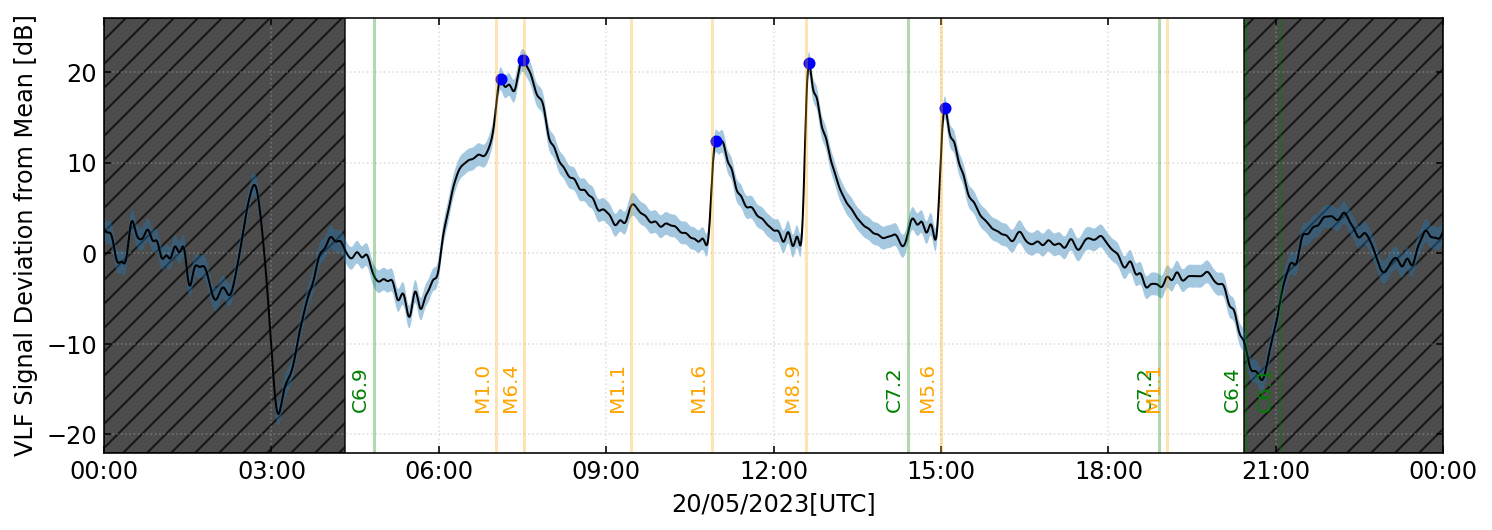

In [18]:
# Create a figure
fig = plt.figure(figsize=(12,4))

ax = plt.gca()

# Plot the raw data (looks quite noisy)
ax.plot(time_dho, vlf_filtered_dB, color='k', lw=1, ls='-', label='VLF DHO Adjusted', alpha=1)

# Set the x label to be the current date in the first time object 
ax.set_xlabel(str(time_dho[0].strftime("%d/%m/%Y"))+ '[UTC]', fontsize=12)
# Set y-value to string below.
ax.set_ylabel('VLF Signal Deviation from Mean [dB]', fontsize=12)

# Set x-axis limit to be start time with a window of 1 day
ax.set_xlim(time_dho[0]+timedelta(hours=0), time_dho[0]+timedelta(hours=24))
# Set y-axis limit to be 80 dB to the max recorded dB in the data +5 dB
ax.set_ylim(int(np.min(vlf_filtered_dB)-5), int(np.max(vlf_filtered_dB)+5))

# Make the x-axis appear in time format (Hours:mins)
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_format)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(bottom=True, top=True, left=True, right=True,direction="in")

#Plots peaks onto graph
for val in (ser):
    time = datetime.strptime(ser[val][0], '%Y-%m-%d %H:%M:%S')
    plt.plot(time, ser[val][1], '.b', ms=10)
    
#Plots GOES flares by class
for flare in cClass:
    plt.vlines(flare['event_peaktime'].datetime,ymin=int(np.min(vlf_filtered_dB)-5), ymax=int(np.max(vlf_filtered_dB)+5), color='green', alpha=0.3)
    plt.text(flare['event_peaktime'].datetime-timedelta(minutes=25),int(np.min(vlf_filtered_dB)),flare['fl_goescls'], c='g', rotation=90)
    
for flare in mClass:
    plt.vlines(flare['event_peaktime'].datetime,ymin=int(np.min(vlf_filtered_dB)-5), ymax=int(np.max(vlf_filtered_dB)+5), color='orange', alpha=0.3)
    plt.text(flare['event_peaktime'].datetime-timedelta(minutes=25),int(np.min(vlf_filtered_dB)),flare['fl_goescls'], c='orange', rotation=90)    
    
for flare in xClass:
    plt.vlines(flare['event_peaktime'].datetime,ymin=int(np.min(vlf_filtered_dB)-5), ymax=int(np.max(vlf_filtered_dB)+5), color='red', alpha=0.3)
    plt.text(flare['event_peaktime'].datetime-timedelta(minutes=25),int(np.min(vlf_filtered_dB)),flare['fl_goescls'], c='r', rotation=90)
    
#Adds black bars at sides to sunrise/sunset times
s = get_sun_info(time_dho[0])    
plt.fill_betweenx([int(np.min(vlf_filtered_dB)-5), int(np.max(vlf_filtered_dB)+5)],time_dho[0],(s["sunrise"]), color='k', alpha=0.7, hatch='//')
plt.fill_betweenx([int(np.min(vlf_filtered_dB)-5), int(np.max(vlf_filtered_dB)+5)],(s["sunset"]),time_dho[-1], color='k', alpha=0.7, hatch='//')

#Adds the up and low segment of tsmoothie filtering
plt.fill_between(time_dho, Noise[1], Noise[2], alpha=0.4)
 
# plot a grid
plt.grid(alpha=0.4, ls='dotted')

plt.show()

In [15]:
#Prints peaks time and intensity
for val in (ser):
    print('There was a peak detected at ' + str(ser[val][0]) + ' with a deviation of ' + str(ser[val][1]) + ' dB from the mean.')

There was a peak detected at 2023-05-20 07:06:34 with a deviation of 19.268776663169543 dB from the mean.
There was a peak detected at 2023-05-20 07:30:06 with a deviation of 21.294334411785403 dB from the mean.
There was a peak detected at 2023-05-20 10:58:18 with a deviation of 12.409419444314835 dB from the mean.
There was a peak detected at 2023-05-20 12:38:06 with a deviation of 20.983071664307964 dB from the mean.
There was a peak detected at 2023-05-20 15:04:10 with a deviation of 16.054875838144824 dB from the mean.
